In [1]:
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy.integrate import dblquad
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, parent_dir)

from dataloader import FastTensorDataLoader

# Data Generation

In [2]:
def generate_poisson_points(kappa, scale, region):
    """
    Generate a Poisson Point Process in a 2D region based on intensity function.
    
    Parameters:
    - kappa (torch.Tensor): The intensity parameter (scalar or vector).
    - scale (torch.Tensor): The scale parameter (scalar or vector).
    - region (tuple): The spatial domain as ((xmin, xmax), (ymin, ymax)).
    
    Returns:
    - points (numpy.ndarray): The simulated points of the PPP.
    """
    (xmin, xmax), (ymin, ymax) = region

    area = (xmax - xmin) * (ymax - ymin)
    max_intensity = kappa * area  # Maximum value of intensity
    num_samples = np.random.poisson(lam=max_intensity)[0]

    x_candidates = np.random.uniform(xmin, xmax, size=num_samples)
    y_candidates = np.random.uniform(ymin, ymax, size=num_samples)
    candidates = torch.tensor(np.stack([x_candidates, y_candidates], axis=1), dtype=torch.float32)
    
    squared_norm = torch.sum(candidates**2, dim=-1)
    intensity = kappa * torch.exp(-squared_norm / scale**2)
    
    uniform_samples = torch.rand(num_samples)  # Uniform samples for rejection
    acceptance_mask = uniform_samples < (intensity / kappa)
    
    accepted_points = candidates[acceptance_mask]
    return accepted_points.numpy()

In [3]:
kappa = torch.tensor([100.0])
scale = torch.tensor([0.5])

region = ((0, 1), (0, 1))

In [4]:
num_samples = 1000
samples = []
for _ in range(num_samples):
    x_t = generate_poisson_points(kappa, scale, region)
    samples.append(torch.tensor(x_t))

## Data Loader

In [5]:
train_ratio = 0.8
batch_size = 32
samples_torch = [torch.tensor(s, dtype=torch.float32) for s in samples]

X = pad_sequence(samples_torch, batch_first=True, padding_value=0)

lengths = torch.tensor([len(s) for s in samples_torch], dtype=torch.int64)
lengths_expanded = lengths.unsqueeze(-1).expand(-1, X.shape[1])
X = torch.cat((X, lengths_expanded.unsqueeze(-1)), dim=-1)

m = len(X)
train_size = int(train_ratio * m)

X_train = X[:train_size]
X_test = X[train_size:]

loader_train = FastTensorDataLoader(X_train, batch_size=batch_size, shuffle=True)
loader_test = FastTensorDataLoader(X_test, batch_size=batch_size, shuffle=False)

C:\Users\79217\AppData\Local\Temp\ipykernel_23532\214776262.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  samples_torch = [torch.tensor(s, dtype=torch.float32) for s in samples]


# Parametric Poisson

## Optimization function

In [6]:
def optimize_theta(loader_train, nn_model, num_epochs=1000, learning_rate=1e-3):
    """
    Optimizes the model parameters.

    Args:
        loader_train (DataLoader): DataLoader for training data.
        nn_model (callable): Function that creates the neural network model.
        num_epochs (int): Number of training epochs.
        learning_rate (float): Learning rate.

    Returns:
        tuple: (trained model, losses, avg_scale_per_epoch)
    """
    model = nn_model()
    optimizer = torch.optim.Rprop(model.parameters(), lr=learning_rate)
    avg_epoch_losses = []
    avg_epoch_real_losses = []
    avg_estimated_scales = []

    pbar = tqdm(range(num_epochs), desc="Training", unit="epoch")

    for _ in pbar:
        epoch_loss_sum = 0
        epoch_real_loss_sum = 0
        num_batches = len(loader_train)

        batch_scales = []

        start_time = time.time()
        for X_batch in loader_train:
            optimizer.zero_grad()

            loss, real_loss = model.loss(X_batch[0])

            loss.backward()
            optimizer.step()

            batch_loss = loss.item()
            batch_real_loss = real_loss.item()
            epoch_loss_sum += batch_loss
            epoch_real_loss_sum += batch_real_loss

            # Store current batch estimate of scale
            batch_scales.append(model.scale.detach().numpy().copy())

        avg_loss = epoch_loss_sum / num_batches
        avg_real_loss = epoch_real_loss_sum / num_batches
        avg_epoch_losses.append(avg_loss)
        avg_epoch_real_losses.append(avg_real_loss)

        # Compute per-epoch average of estimated scale
        avg_estimated_scales.append(sum(batch_scales) / len(batch_scales))

        elapsed_time = time.time() - start_time
        pbar.set_postfix({
            "Train Loss": f"{avg_loss:.4f}",
            "Real Loss": f"{avg_real_loss:.4f}",
            "Time/Epoch": f"{elapsed_time:.2f}s"
        })
    
    return model, avg_epoch_losses, avg_epoch_real_losses, avg_estimated_scales

## Poisson Model

In [7]:
class Poisson(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(123)
        self.scale = nn.Parameter(torch.tensor([torch.abs(torch.randn(1))], dtype=torch.float32))

    def forward(self, x):
        squared_norm = torch.sum(x**2, dim=-1)
        return - squared_norm / self.scale**2

    def compute_psi(self, x):
        x.requires_grad_()
        nn_output = self.forward(x)
        psi = torch.autograd.grad(nn_output, x, grad_outputs=torch.ones_like(nn_output), create_graph=True)[0]
        return psi
    
    def poisson_psi(self, x):
        return -2*x/self.scale**2
    
    def J(self, x_t, lengths):
        max_length = lengths.max()
        psi_x = self.poisson_psi(x_t)  

        norm_squared = (psi_x ** 2).sum(dim=-1) 

        divergence = -2 / self.scale**2 * x_t.shape[-1]
        mask = torch.arange(max_length, device=x_t.device).unsqueeze(0) < lengths.unsqueeze(1)
        divergence = divergence*mask
        norm_squared = norm_squared*mask

        J_value = divergence + 0.5 * norm_squared
        J_value = J_value.sum(dim=-1) / lengths

        return J_value.mean()

    def loss(self, points):
        lengths = points[:, 0, -1].to(dtype=torch.int64)
        max_length = lengths.max()
        x_t = points[:, :max_length, :-1]  # Pad to max length in batch
 
        psi_x = self.compute_psi(x_t)
        psi_x_real = self.poisson_psi(x_t)

        if not torch.allclose(psi_x, psi_x_real, atol=1e-4):
            raise ValueError(
                f"Calculated psi value {psi_x} \
                is different from the analytical solution {psi_x_real}"
                )
        norm_squared = (psi_x ** 2).sum(dim=-1)  # Sum across all dimensions

        # padded values give none zero divergence -> mask 
        mask = torch.arange(max_length, device=x_t.device).unsqueeze(0) < lengths.unsqueeze(1)
        divergence = 0
        for i in range(x_t.shape[-1]):  # Iterate over the features of x
            gradient = torch.autograd.grad(psi_x[..., i].sum(), x_t, retain_graph=True, create_graph=True)[0]
            divergence += gradient[..., i]  # Sum over each feature dimension
        
        divergence = divergence * mask
        norm_squared = norm_squared * mask
        
        total_loss = 0.5 * norm_squared + divergence
        total_loss = total_loss.sum(dim=-1)/lengths  # Sum over the time dimension
        J = self.J(x_t, lengths)
        if not torch.allclose(total_loss.mean(), J, atol=1e-4):
            raise ValueError(
                f"Calculated total loss value {total_loss.mean()} \
                is different from the analytical solution {J}"
                )
        
        return total_loss.mean(), J

### Batch processing

In [8]:
epochs = 100
model, losses, real_losses, estimated_scale = optimize_theta(
    loader_train, Poisson, num_epochs=epochs, learning_rate=1e-3,
)

Training: 100%|██████████| 100/100 [00:14<00:00,  6.81epoch/s, Train Loss=-8.4424, Real Loss=-8.4424, Time/Epoch=0.15s]  


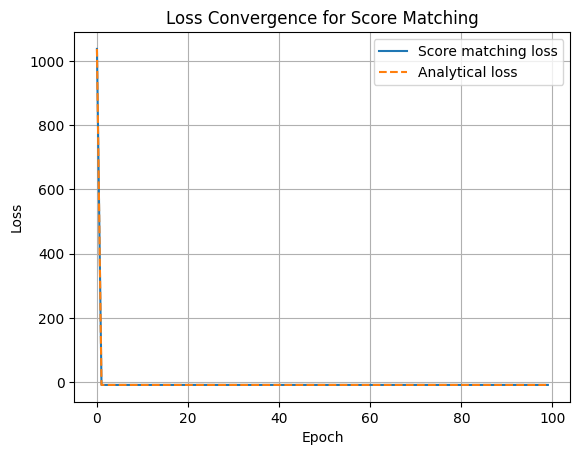

In [9]:
plt.plot(losses, label="Score matching loss")
plt.plot(real_losses, linestyle='--', label="Analytical loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Convergence for Score Matching')
plt.legend()
plt.grid(True)
plt.show()


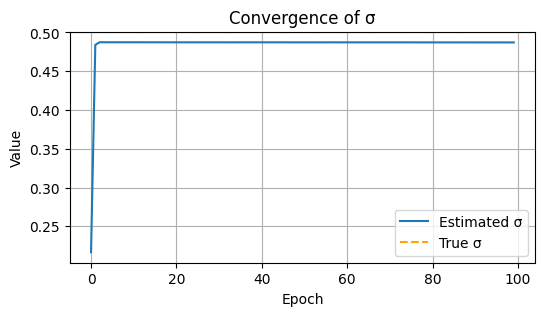

In [10]:
plt.figure(figsize=(6, 3))
plt.plot(estimated_scale, label="Estimated σ")
plt.axhline(scale, color='orange', linestyle='--', label="True σ")
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.title('Convergence of σ')
plt.show()

In [11]:
print("Estimated scale:", model.scale)
print("True scale:", scale)

Estimated scale: Parameter containing:
tensor([0.4871], requires_grad=True)
True scale: tensor([0.5000])


### Kappa Inference

In [12]:
def infer_kappa(x_t, sigma, region):
    """
    Infers the parameter kappa for the Poisson Point Process intensity function
    given the data x_t and the known scale parameter sigma.
    
    Args:
    - x_t: numpy array of shape (n, d), where n is the number of data points and d is the dimension of the data.
    - sigma: the known scale parameter (positive real number).
    
    Returns:
    - kappa: the inferred scaling factor for the intensity function.
    """
    (a1, b1), (a2, b2) = region
    n = len(x_t)
    
    def integrand(x0, x1, sigma):
        return np.exp(-(x0**2 + x1**2) / sigma**2)

    integral_result, _ = dblquad(integrand, a1, b1, lambda x0: a2, lambda x0: b2, args=(sigma,))
    
    kappa = n / integral_result
    return kappa

In [13]:
kappa = infer_kappa(x_t, model.scale.detach().numpy(), region)
print(f"Inferred kappa: {kappa}")

Inferred kappa: 108.11715955920079
